# EDA — SaaS Product Usage Churn

**Goal:** Understand churn behavior in a subscription-based digital product and identify early signals from usage, engagement, and friction variables.

**Questions to answer:**
1. What is the churn rate and is the target imbalanced?
2. How do usage patterns differ between churned vs retained customers?
3. Are friction signals (support tickets, payment failures) associated with churn?
4. Are churn patterns different across plan types and pricing?
5. What hypotheses should we validate with modeling?




In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from pathlib import Path 

pd.set_option("display.max_columns", 200)
pd.set_option("display.width",140)



In [44]:
DATA_PATH=Path("../data/raw") 
csv_files=list(DATA_PATH.glob("*.csv"))

csv_files

[PosixPath('../data/raw/customer_subscription_churn_usage_patterns.csv')]

In [45]:
df=pd.read_csv(csv_files[0])
df.shape

(2800, 10)

In [46]:
df.head()

,user_id,signup_date,plan_type,monthly_fee,avg_weekly_usage_hours,support_tickets,payment_failures,tenure_months,last_login_days_ago,churn
0,1,2023-04-15,Premium,699,1.1,4,1,8,14,Yes
1,2,2023-08-27,Premium,699,2.6,6,0,35,1,Yes
2,3,2023-10-12,Premium,699,14.3,8,3,2,14,Yes
3,4,2023-12-11,Basic,199,17.6,5,2,11,9,Yes
4,5,2023-02-14,Basic,199,9.8,5,2,6,38,Yes


In [47]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 2800 non-null   int64  
 1   signup_date             2800 non-null   str    
 2   plan_type               2800 non-null   str    
 3   monthly_fee             2800 non-null   int64  
 4   avg_weekly_usage_hours  2800 non-null   float64
 5   support_tickets         2800 non-null   int64  
 6   payment_failures        2800 non-null   int64  
 7   tenure_months           2800 non-null   int64  
 8   last_login_days_ago     2800 non-null   int64  
 9   churn                   2800 non-null   str    
dtypes: float64(1), int64(6), str(3)
memory usage: 218.9 KB


In [48]:
df.describe(include="all")

,user_id,signup_date,plan_type,monthly_fee,avg_weekly_usage_hours,support_tickets,payment_failures,tenure_months,last_login_days_ago,churn
count,2800.000000,2800,2800,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800
unique,NaN,710,3,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,2024-05-02,Premium,NaN,NaN,NaN,NaN,NaN,NaN,Yes
freq,NaN,10,944,NaN,NaN,NaN,NaN,NaN,NaN,1605
mean,1400.500000,NaN,NaN,434.214286,12.891429,3.887857,2.491786,18.612857,30.005000,NaN
std,808.434702,NaN,NaN,205.678472,7.109691,2.606419,1.691647,10.374487,17.852757,NaN
min,1.000000,NaN,NaN,199.000000,0.500000,0.000000,0.000000,1.000000,0.000000,NaN
25%,700.750000,NaN,NaN,199.000000,6.700000,2.000000,1.000000,10.000000,14.000000,NaN
50%,1400.500000,NaN,NaN,399.000000,12.800000,4.000000,2.000000,18.000000,30.000000,NaN
75%,2100.250000,NaN,NaN,699.000000,19.200000,6.000000,4.000000,27.000000,46.000000,NaN


In [49]:
df.columns=[c.strip().lower() for c in df.columns] 

In [50]:
df

,user_id,signup_date,plan_type,monthly_fee,avg_weekly_usage_hours,support_tickets,payment_failures,tenure_months,last_login_days_ago,churn
0,1,2023-04-15,Premium,699,1.1,4,1,8,14,Yes
1,2,2023-08-27,Premium,699,2.6,6,0,35,1,Yes
2,3,2023-10-12,Premium,699,14.3,8,3,2,14,Yes
3,4,2023-12-11,Basic,199,17.6,5,2,11,9,Yes
4,5,2023-02-14,Basic,199,9.8,5,2,6,38,Yes
...,...,...,...,...,...,...,...,...,...,...
2795,2796,2023-03-10,Standard,399,6.7,1,1,21,59,No
2796,2797,2024-11-20,Standard,399,11.0,4,0,6,4,No
2797,2798,2024-08-13,Standard,399,11.0,0,4,22,59,No
2798,2799,2024-05-23,Premium,699,15.0,3,4,25,20,No


In [51]:
df["churn"]= df["churn"].astype(str).str.strip().str.lower().map({"yes":1, "no":0})
df["churn"].value_counts(dropna=False)

churn
1    1605
0    1195
Name: count, dtype: int64

In [52]:
df

,user_id,signup_date,plan_type,monthly_fee,avg_weekly_usage_hours,support_tickets,payment_failures,tenure_months,last_login_days_ago,churn
0,1,2023-04-15,Premium,699,1.1,4,1,8,14,1
1,2,2023-08-27,Premium,699,2.6,6,0,35,1,1
2,3,2023-10-12,Premium,699,14.3,8,3,2,14,1
3,4,2023-12-11,Basic,199,17.6,5,2,11,9,1
4,5,2023-02-14,Basic,199,9.8,5,2,6,38,1
...,...,...,...,...,...,...,...,...,...,...
2795,2796,2023-03-10,Standard,399,6.7,1,1,21,59,0
2796,2797,2024-11-20,Standard,399,11.0,4,0,6,4,0
2797,2798,2024-08-13,Standard,399,11.0,0,4,22,59,0
2798,2799,2024-05-23,Premium,699,15.0,3,4,25,20,0


In [53]:
missing=df.isna().mean().sort_values(ascending=False) 
missing[missing>0]



Series([], dtype: float64)

In [54]:
df.duplicated().sum()

np.int64(0)

In [55]:
df.columns

Index(['user_id', 'signup_date', 'plan_type', 'monthly_fee', 'avg_weekly_usage_hours', 'support_tickets', 'payment_failures',
       'tenure_months', 'last_login_days_ago', 'churn'],
      dtype='str')

In [56]:
df["churn"].value_counts(dropna=False), df["churn"].dtype


(churn
 1    1605
 0    1195
 Name: count, dtype: int64,
 dtype('int64'))

In [57]:
churn_rate=df["churn"].mean()

print(f"Churn rate: {churn_rate:.2%}")

Churn rate: 57.32%


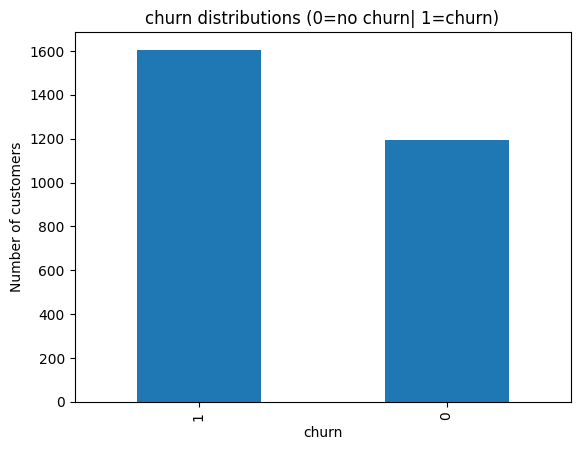

In [58]:
df["churn"].value_counts().plot(kind="bar") 
plt.title("churn distributions (0=no churn| 1=churn)")
plt.xlabel("churn")
plt.ylabel("Number of customers") 
plt.show() 

In [62]:
df.head()

,user_id,signup_date,plan_type,monthly_fee,avg_weekly_usage_hours,support_tickets,payment_failures,tenure_months,last_login_days_ago,churn
0,1,2023-04-15,Premium,699,1.1,4,1,8,14,1
1,2,2023-08-27,Premium,699,2.6,6,0,35,1,1
2,3,2023-10-12,Premium,699,14.3,8,3,2,14,1
3,4,2023-12-11,Basic,199,17.6,5,2,11,9,1
4,5,2023-02-14,Basic,199,9.8,5,2,6,38,1


In [59]:
df.groupby("churn")["tenure_months"].describe()


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,1195.0,18.588285,10.364603,1.0,10.0,18.0,27.0,36.0
1,1605.0,18.631153,10.385033,1.0,10.0,18.0,27.0,36.0


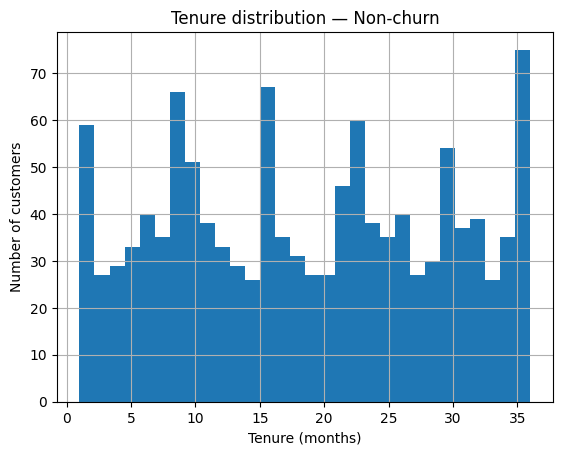

In [60]:
df[df["churn"] == 0]["tenure_months"].hist(bins=30)
plt.title("Tenure distribution — Non-churn")
plt.xlabel("Tenure (months)")
plt.ylabel("Number of customers")
plt.show()


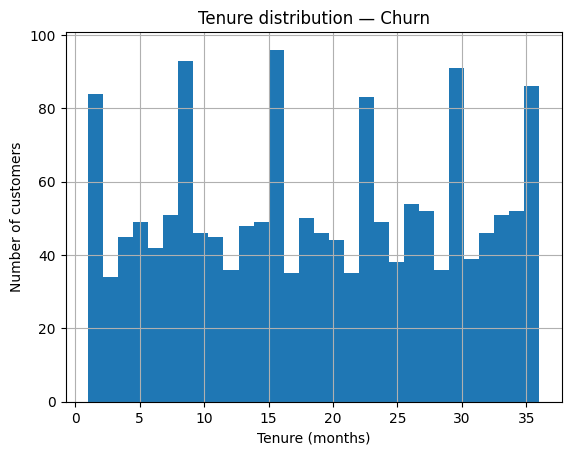

In [61]:
df[df["churn"] == 1]["tenure_months"].hist(bins=30)
plt.title("Tenure distribution — Churn")
plt.xlabel("Tenure (months)")
plt.ylabel("Number of customers")
plt.show()


In [63]:
df.groupby("churn")[["avg_weekly_usage_hours", "last_login_days_ago"]].describe()


avg_weekly_usage_hours                                                   last_login_days_ago                                         \
                       count       mean       std  min   25%   50%   75%   max               count       mean        std  min   25%   50%   
churn                                                                                                                                       
0                     1195.0  13.746444  6.609131  0.5  8.35  13.9  19.3  25.0              1195.0  26.149791  18.204317  0.0  10.0  22.0   
1                     1605.0  12.254829  7.398706  0.5  5.10  12.1  19.1  25.0              1605.0  32.875389  17.034274  0.0  20.0  34.0   

                   
        75%   max  
churn              
0      42.0  60.0  
1      47.0  60.0

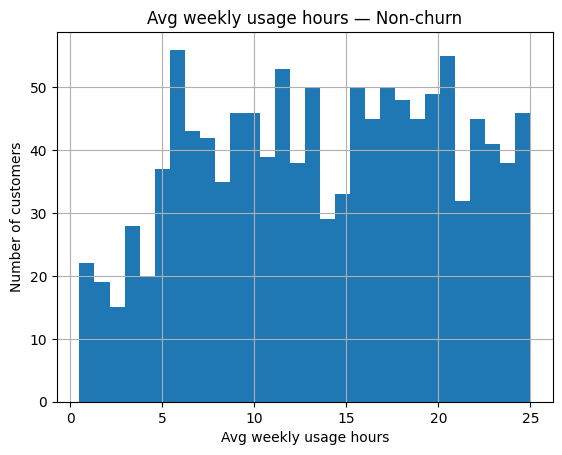

In [64]:
df[df["churn"] == 0]["avg_weekly_usage_hours"].hist(bins=30)
plt.title("Avg weekly usage hours — Non-churn")
plt.xlabel("Avg weekly usage hours")
plt.ylabel("Number of customers")
plt.show()


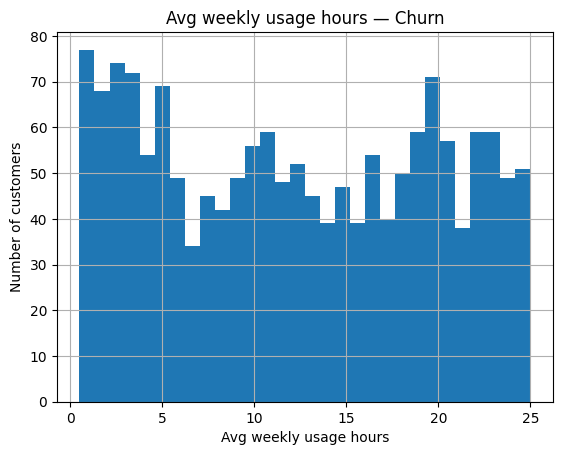

In [65]:

df[df["churn"] == 1]["avg_weekly_usage_hours"].hist(bins=30)
plt.title("Avg weekly usage hours — Churn")
plt.xlabel("Avg weekly usage hours")
plt.ylabel("Number of customers")
plt.show()

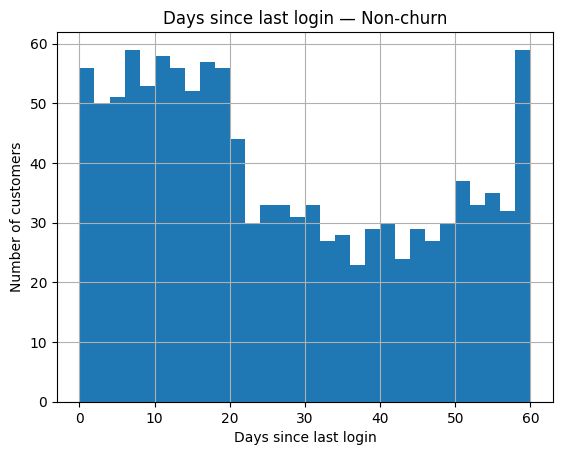

In [66]:
df[df["churn"] == 0]["last_login_days_ago"].hist(bins=30)
plt.title("Days since last login — Non-churn")
plt.xlabel("Days since last login")
plt.ylabel("Number of customers")
plt.show()


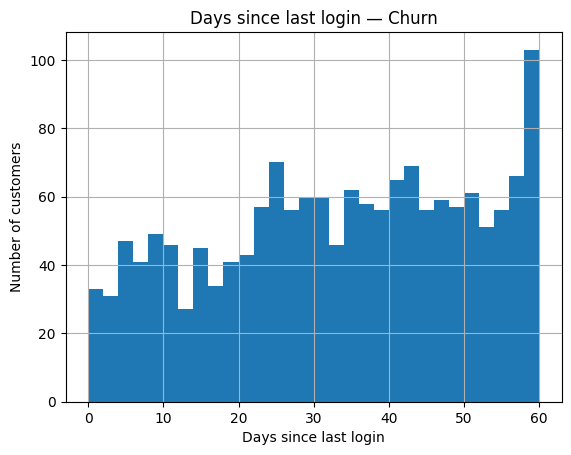

In [67]:
df[df["churn"] == 1]["last_login_days_ago"].hist(bins=30)
plt.title("Days since last login — Churn")
plt.xlabel("Days since last login")
plt.ylabel("Number of customers")
plt.show()

In [68]:
df.groupby("churn")[["support_tickets", "payment_failures"]].describe()


support_tickets                                              payment_failures                                             
                count      mean       std  min  25%  50%  75%  max            count      mean       std  min  25%  50%  75%  max
churn                                                                                                                           
0              1195.0  3.435983  2.565369  0.0  1.0  3.0  6.0  8.0           1195.0  2.072803  1.711784  0.0  1.0  2.0  4.0  5.0
1              1605.0  4.224299  2.586563  0.0  2.0  5.0  6.0  8.0           1605.0  2.803738  1.607568  0.0  2.0  3.0  4.0  5.0

## EDA Summary & Modeling Hypotheses

### Key Insights
- 
- 
- 
-

### Modeling Hypotheses
- H1:
- H2:
- H3:
